In [40]:
"""
This file contains functions that are written utils/gates/snail_death_gate.py
Refactoring note, should call functions from there instead of writing them here
"""

'\nThis file contains functions that are written utils/gates/snail_death_gate.py\nRefactoring note, should call functions from there instead of writing them here\n'

In [41]:
import matplotlib.pyplot as plt
import numpy as np

c_ampArray = np.linspace(0, 0.8, 81)
g_ampArray = np.linspace(0, 0.8, 81)

from slam.utils.data_utils import h5py_load
glist = h5py_load("snail_death", "snail_death")["snail_death"]

def check_snail(gc, gg):
    """returns true if snail still alive"""
    c_ampArray = np.linspace(0, 0.8, 81)
    g_ampArray = np.linspace(0, 0.8, 81)

    x = np.where(c_ampArray == gc)[0]
    y = np.where(g_ampArray == gg)[0]
    return glist.T[x,y] > 0.5

def get_speedlimit(gc, gg):
    """Find highest amps (preserving gate ratio) where snail still alive
    TODO Make this way smarter by using parametric functions and finding intercepts!
    Failing now because not all values are contained in glist linspace array"""
    upper_bound_scale = np.min([0.8/gc, 0.8/gg])
    scale = upper_bound_scale
    y= lambda x: gg/gc
    while (gc > 1e-6 and gg > 1e-6) and scale > 0:
        sc, sg = gc*scale, gg*scale
        scale -= .01 #shrink ratio until valid
        if check_snail(sc, sg):
            break
    return sc, sg

TypeError: 'NoneType' object is not subscriptable

In [ ]:
plt.figure()
plt.pcolormesh(g_ampArray, c_ampArray, glist.T, cmap='RdBu', vmax=1, vmin=0)
plt.xlabel("gain amp(DAC)")
plt.ylabel('conv amp(DAC)')
cbar = plt.colorbar()
plt.ylim(0,.8)
plt.xlim(-0.01,.8)
cbar.set_label("g pct", rotation=90)

NameError: name 'glist' is not defined

<Figure size 640x480 with 0 Axes>

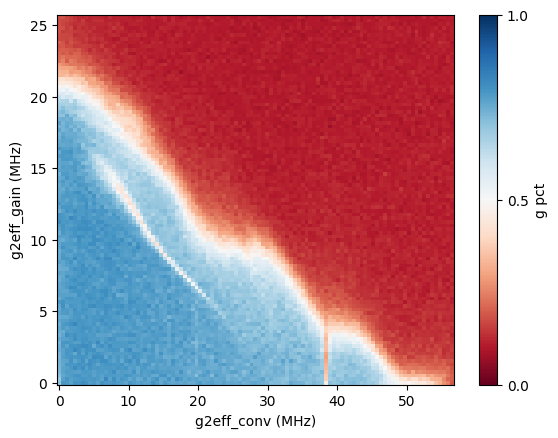

In [42]:
import json
from matplotlib import pyplot as plt
import numpy as np

from config import srcpath
datapath = f"{srcpath}/data/Q1_11.07mA_snailPump_length0.5_prepareE_False_freqG_9070_freqC_695-11_processed.json"

dd = json.load(open(datapath))
g2_conv = dd["g2_conv"]
g2_gain = dd["g2_gain"]
g_pct = np.array(dd["g_pct"])


plt.figure()
plt.pcolormesh(g2_conv, g2_gain, g_pct.T, shading='auto', cmap='RdBu', vmin=0, vmax=1)
plt.xlabel(f"g2eff_conv (MHz)")
plt.ylabel(f"g2eff_gain (MHz)")

# plt.xticks(np.linspace(0, 50, 6), map(str, np.linspace(0, 50, 6, dtype=int)))
# plt.yticks(np.linspace(0, 15, 4), map(str, np.linspace(0, 15, 4, dtype=int)))


cbar = plt.colorbar()
cbar.set_label("g pct", rotation=90)
cbar.set_ticks([0.0, 0.5, 1.0])

# namign variables to match old version
glist = g_pct
c_ampArray = g2_conv
g_ampArray = g2_gain


In [43]:
# step 1 data cleaning
glist_temp = glist.copy().T
# iterate through each column
for i in range(glist_temp.shape[1]):
    # find the last value close to 0.5
    idx = np.where(np.isclose(glist_temp[:,i], 0.5, atol=.05))[0]
    if len(idx) > 0:
        idx = idx[-1]
    else:
        # set all values to 0
        glist_temp[:,i] = 0
        continue
    # set all values before that to 0
    glist_temp[:idx,i] = 0
    # set that value to 1
    glist_temp[idx,i] = 1
    # set every value after that to 0
    glist_temp[idx+1:,i] = 0

In [44]:
# remove the obvious outlier
glist_temp[0, 68] = 0

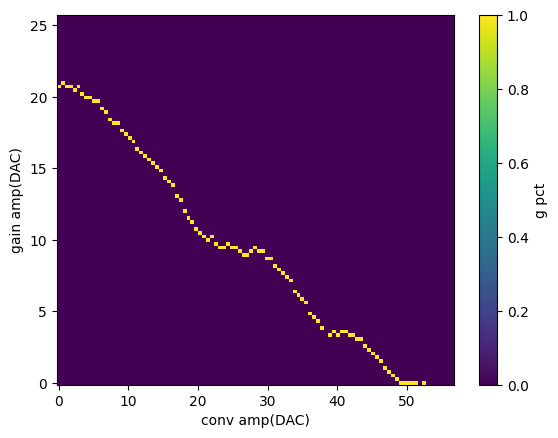

In [45]:
plt.figure()
plt.pcolormesh(c_ampArray, g_ampArray, glist_temp, vmax=1, vmin=0)
plt.ylabel("gain amp(DAC)")
plt.xlabel('conv amp(DAC)')
cbar = plt.colorbar()
cbar.set_label("g pct", rotation=90)

In [46]:
#step 2 reduce dimensionality
coords = []
for i in range(glist_temp.shape[0]):
    for j in range(glist_temp.shape[1]):
        if glist_temp[i,j] == 1:
            coords.append([c_ampArray[j], g_ampArray[i]])

coords.sort(key=lambda x: x[0])

In [47]:
# add in point (1,0) to make sure bounded
coords.append([coords[-1][0],0])

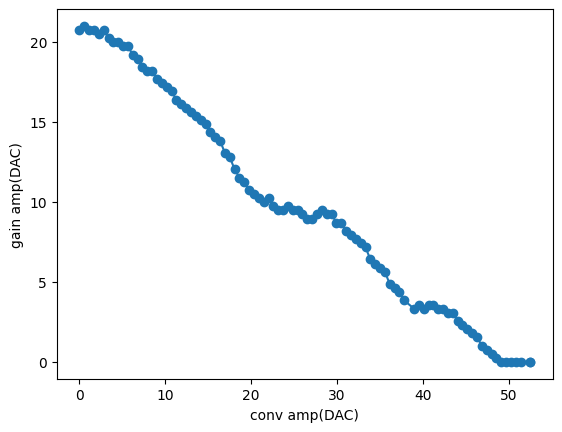

In [48]:
plt.figure()
plt.plot([x[0] for x in coords], [x[1] for x in coords], '-o')
plt.ylabel("gain amp(DAC)")
plt.xlabel('conv amp(DAC)')
cbar.set_label("g pct", rotation=90)

In [ ]:
# # don't have to do because already scaled in new data 
# # use conv_data and gain_data to see how voltage is related to the gc/gg terms in order to scale the axes properly
# # load from data conv_data and gain_data using h5py
# import h5py
# with h5py.File('data/conv_data.h5', 'r') as hf:
#     plt.plot(hf['DAC_list'][:], hf['g2_fit'][:], '-o', label='conv')
#     # save slope
#     conv_slope = np.average(hf['g2_fit'][:]/hf['DAC_list'][:])

# with h5py.File('data/gain_data.h5', 'r') as hf:
#     plt.plot(hf['DAC_list'][:], hf['g2_fit'][:], '-o', label='gain')
#     # save slope
#     gain_slope = np.average(hf['g2_fit'][:]/hf['DAC_list'][:])

# plt.legend()
# plt.xlabel('DAC')
# plt.ylabel('g2')
# #print slopes
# print(conv_slope, gain_slope)

In [49]:
#step 2.5 arbitrary scaling to convert DAC to Hamiltonian (rad/s) ?
real_scaling = 1
conv_slope =1
gain_slope = 1
# slopes are 1 because already scaled in new data

if real_scaling:
    #decide to scale so x and y intercept are near pi/2
    #scale x axis
    x = [x[0]*conv_slope for x in coords] #0.64*np.pi
    # scale y axis
    y = [x[1]*gain_slope for x in coords] #1.7*np.pi

    # step 2.6 normalization so the maximum intercept is pi/2
    # find max between x- and y-axis intercept
    max_intercept = np.max([np.abs(x[-1]), np.abs(y[0])])
    # scale x and y
    x = [x[i]/max_intercept*np.pi/2 for i in range(len(x))]
    y = [y[i]/max_intercept*np.pi/2 for i in range(len(y))]

else:
    #scale x axis
    x = [x[0]*0.64*np.pi for x in coords] #
    # scale y axis
    y = [x[1]*1.7*np.pi for x in coords] #

[0.44116428] [0.44116428]
[0.83726902] [0.27908967]


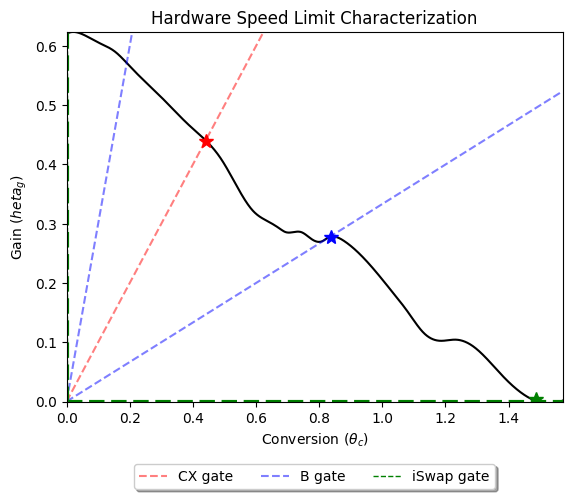

In [90]:
# step 3 univariate spline
from scipy.interpolate import UnivariateSpline
N=1500
s = UnivariateSpline(x, y, s=0.001)
xs = np.linspace(0, max(x), N)
plt.figure()
# plt.plot(x, y, 'o', xs, s(xs), '-', label="Characterized Speed Limit")
plt.plot(xs, s(xs), '-', color='black')#, label="Characterized Speed Limit")
plt.ylabel("Gain ($\theta_g$)")
plt.xlabel(r'Conversion ($\theta_c$)')
plt.xlim(0,max(xs))
plt.ylim(0,max(s(xs)))

# #also put linear fit on plot
# s2 = lambda x: -x + np.pi/2
# xs = np.linspace(0, np.pi/2, N)
# plt.plot(xs, s2(xs), 'g-', label='Linear Speed Limit')

# slf = lambda x: np.sqrt((np.pi/2)**2 - x**2)
# plt.plot(xs, slf(xs), 'r-', label='Squared Speed Limit')

# c = np.pi/4
# slf = lambda x: 0.5 * (-2*c + np.sqrt(4*c**2 - 8*c*x  + 4*c*np.pi - 4*x**2 + np.pi**2))
# plt.plot(xs, slf(xs), 'b-', label='Mid Speed Limit')

#plot cnot gate
gate_c = 0.25*np.pi
gate_g = 0.25*np.pi
if gate_c == 0:
    plt.plot([0, 0], [0, max(s(xs))], 'r--', label='CX gate')
else:
    ratio = gate_g/gate_c * xs
    plt.plot(xs, ratio, 'r--', label='CX gate', alpha=0.5)

#plot intersections
if gate_c == 0:
    idx = 0
    print(xs[idx], s(xs[idx]))
else:
    idx = max(np.argwhere(np.abs(ratio - s(xs)) < 0.001))
    print(xs[idx], ratio[idx])
plt.plot(xs[idx], s(xs[idx]), 'r*', markersize=10)


# plot B gate
gate_c = 1*np.pi/8
gate_g =3*np.pi/8
ratio = gate_g/gate_c * xs
plt.plot(xs, ratio, 'b--', label='B gate', alpha=0.5)
gate_c = 3*np.pi/8
gate_g = 1*np.pi/8
ratio = gate_g/gate_c * xs
plt.plot(xs, ratio, 'b--', alpha=0.5)

# plot iSwap gate
# x=0
# plot using vline
# make a bit thicker for visibility
plt.axvline(0, color='green', linestyle='--', label='iSwap gate', linewidth=1)
plt.axvline(0, color='green', linestyle='--', linewidth=3)
#yp=0
plt.axhline(0, color='green', linestyle='--', linewidth=3)


#plot intersections
if gate_c == 0:
    idx = 0
    print(xs[idx], s(xs[idx]))
else:
    idx = max(np.argwhere(np.abs(ratio - s(xs)) < 0.001))
    print(xs[idx], ratio[idx])
plt.plot(xs[idx], s(xs[idx]), 'b*', markersize=10)

# plot iswap intersection as just y=0 
plt.plot(xs[-82], .005, 'g*', markersize=10)

# idx = max(np.argwhere(np.abs(ratio - s2(xs)) < 0.01))
# plt.plot(xs[idx], s2(xs[idx]), 'gP', markersize=8)

plt.title("Hardware Speed Limit Characterization")
#show legend underneath plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
# save as pdf
plt.savefig('speed_limit22.pdf')

plt.show()

# Making plots for best gate on SL chart

In [17]:
from slam.utils.gates.bare_candidates import build_gates, get_group_name
from slam.utils.gates.duraton_scaling import cost_scaling, atomic_cost_scaling
from slam.utils.gates.winner_selection import pick_winner
unitary_list, coordinate_list = build_gates()
#coordinate_2dlist_weyl(*coordinate_list);
# collect_data(unitary_list)

/tmp/ipykernel_446/2982240770.py:41: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax2.w_zaxis.line.set_lw(0.)
0it [03:14, ?it/s]


TypeError: 'NoneType' object is not subscriptable

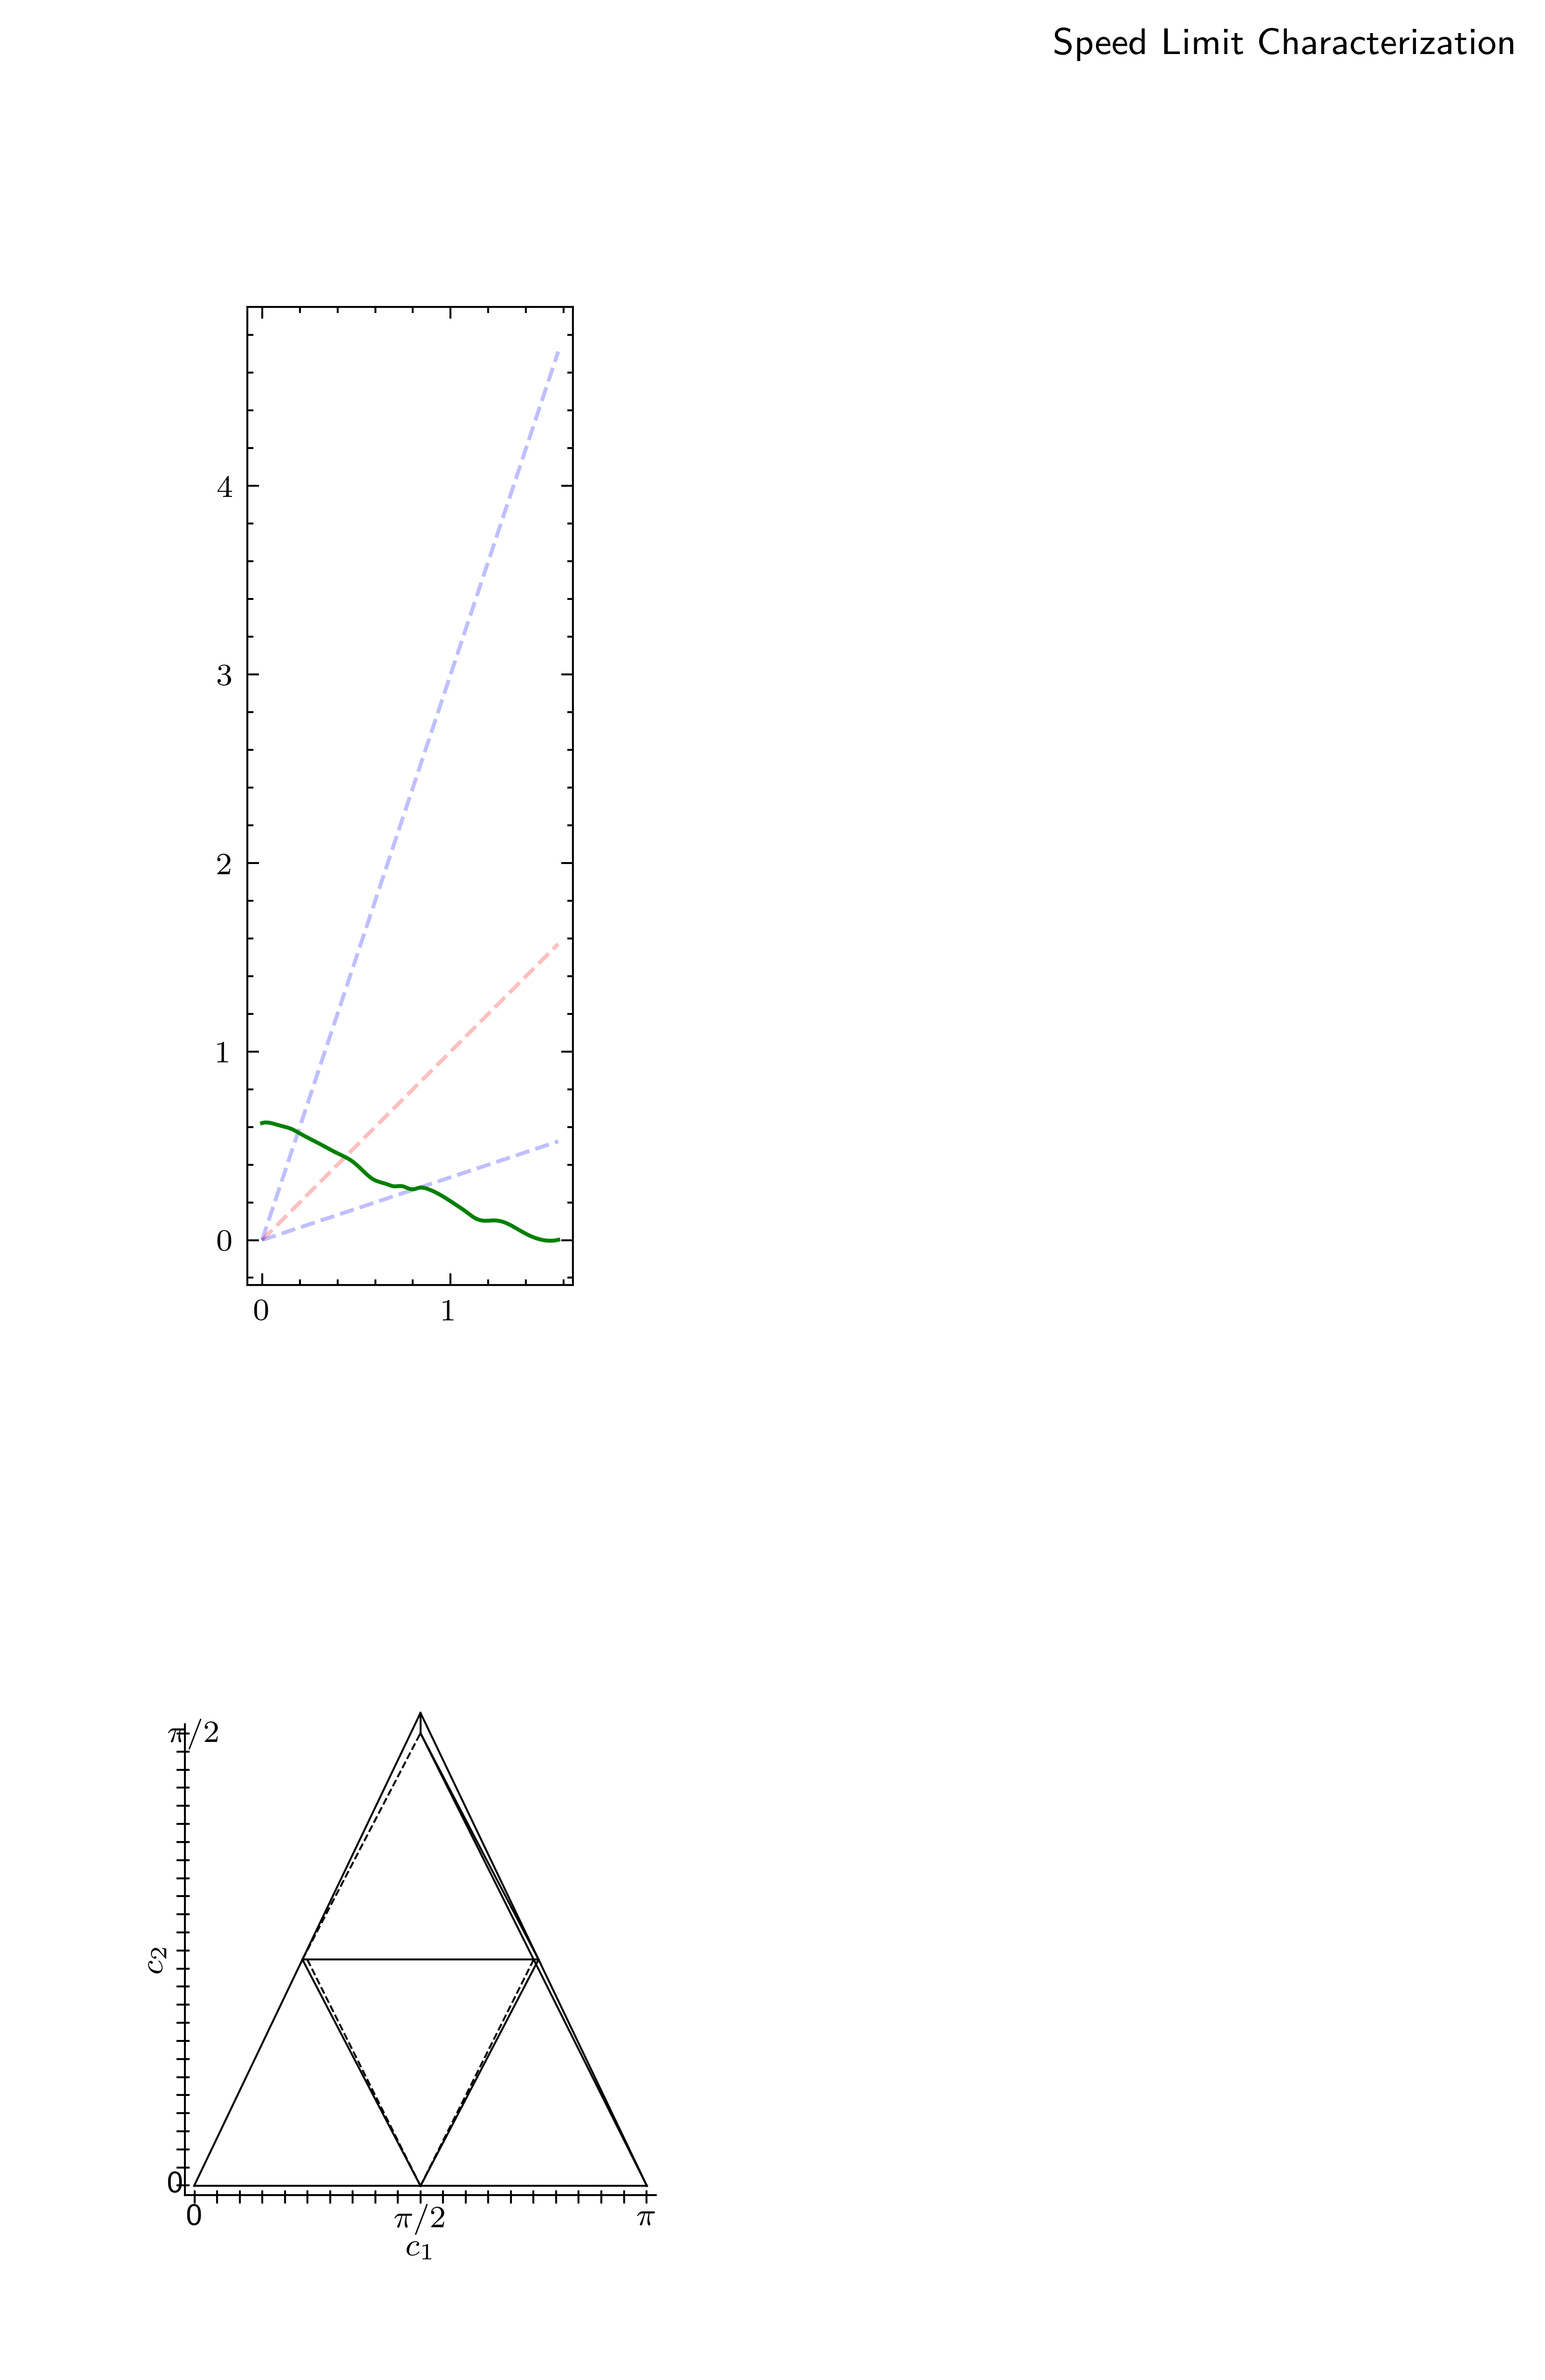

In [21]:
# step 3 univariate spline
from scipy.interpolate import UnivariateSpline
from weylchamber import WeylChamber, c1c2c3
from tqdm import tqdm
N=800
slf_hardware = UnivariateSpline(x, y, s=0.001)
xs = np.linspace(0, max(x), N)

# make a subfigure for each 1Q duration
durations_1q = [0, 0.1, 0.25]#, 0.5]
with plt.style.context(['science','ieee']):
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle("Speed Limit Characterization")
    for index, duration_1q in enumerate(durations_1q):

        ax = fig.add_subplot(2, len(durations_1q), index+1)
        # add second row of subfigures, set to be same size as first row
        # ax2 = fig.add_subplot(2, len(durations_1q), 1+len(durations_1q)+index, projection="3d", figsize=(16,4))
        ax2 = fig.add_subplot(2, len(durations_1q), 1+len(durations_1q)+index, projection="3d")
        
        #set ax2 camera view to be top down
        w = WeylChamber()
        w.weyl_edge_bg_properties = {'color': 'k', 'linewidth': 0}
        w.fig_height = 8
        w.fig_width = 8
        w.top_margin =0
        w.bottom_margin = 0
        w.left_margin = 0
        w.right_margin = 0

        w.elev = 90
        w.azim = -90
        #remove labels
        w.labels = {}
        w.render(ax2)

        # scale subplots to be same height and width
        ax.set_aspect('equal')
        # ax2.set_aspect('auto')
        # set the z axis to be invisible
        ax2.w_zaxis.line.set_lw(0.)
        ax2.set_zticks([])
        ax2.set_zlabel('')
        #ax2.get_zaxis().set_visible(False)

        # REFERENCE GATES
        #plot cnot gate
        gate_c = 0.25*np.pi
        gate_g = 0.25*np.pi
        if gate_c == 0:
            ax.plot([0, 0], [0, max(s(xs))], 'r--', label='CX gate')
        else:
            ratio = gate_g/gate_c * xs
            ax.plot(xs, ratio, 'r--', label='CX gate', alpha=0.25)

        # plot B gate
        gate_c = 3*np.pi/8
        gate_g = 1*np.pi/8
        ratio = gate_g/gate_c * xs
        ax.plot(xs, ratio, 'b--', label='B gate', alpha=0.25)
        gate_c = 1*np.pi/8
        gate_g = 3*np.pi/8
        ratio = gate_g/gate_c * xs
        ax.plot(xs, ratio, 'b--', alpha=0.25)
        ##############

        # method_list = ['linear', 'squared', 'hardware'] #'mid'
        method_list = ['hardware']
        #color for each method
        colors = ['g', 'r', 'b', 'k']
        for method_i, method in tqdm(enumerate(method_list)):

            if method == 'hardware':
                # plt.plot(x, y, 'o', xs, s(xs), '-', label="Characterized Speed Limit")
                ax.plot(xs, slf_hardware(xs), label="Characterized Speed Limit", color=colors[method_i], linestyle='-')
                s_method = slf_hardware

            elif method == 'linear':
                #also put linear fit on plot
                slf_linear = lambda x: -x + np.pi/2
                xs = np.linspace(0, np.pi/2, N)
                ax.plot(xs, slf_linear(xs), label='Linear Speed Limit',color=colors[method_i], linestyle='-')
                s_method = slf_linear

            elif method == 'squared':
                slf_squared = lambda x: np.sqrt((np.pi/2)**2 - x**2)
                ax.plot(xs, slf_squared(xs), label='Squared Speed Limit',color=colors[method_i], linestyle='-')
                s_method = slf_squared

            elif method == 'mid':
                c = np.pi/4
                slf_mid = lambda x: 0.5 * (-2*c + np.sqrt(4*c**2 - 8*c*x  + 4*c*np.pi - 4*x**2 + np.pi**2))
                ax.plot(xs, slf_mid(xs), label='Mid Speed Limit', color=colors[method_i], linestyle='-')
                s_method = slf_mid

            for m_i, metric in enumerate([0,1,2, (-1, .47)]):
                # matplotlib marker and color unique to each metric
                marker = ['o', 'P', '*', 's'][m_i]
                label = ['Haar', 'CX', 'SWAP', 'W(.47)'][m_i]
                color = colors[method_i]
                # add a legend entry for each metric


                group_name = get_group_name(method, duration_1q)
                cost_scaling(speed_method=method, duration_1q=duration_1q)
                gate = pick_winner(group_name, metric=metric, plot=False, tqdm_bool=False)[0]
                gate_c ,gate_g = gate.params[2], gate.params[3]
                # # XXX rewrite using atomic cost function
                # # raise NotImplementedError("This code is not updated to use the new atomic cost function")
                # for candidate_gate in unitary_list:
                #     scaled_gate, _ = atomic_cost_scaling(candidate_gate.params, scores=

                
                # plot intersections
                if gate_c == 0:
                    idx = 0
                    #print(xs[idx], s_method(xs[idx]))
                else:
                    ratio = gate_g/gate_c * xs
                    idx = max(np.argwhere(np.abs(ratio - s_method(xs)) < 0.02))
                    #print(xs[idx], ratio[idx])

                # only label the last metric
                if duration_1q == durations_1q[-1] and method == method_list[-1]:
                    ax.plot(xs[idx], s_method(xs[idx]), color+marker, markersize=10, label=label)
                else:
                    ax.plot(xs[idx], s_method(xs[idx]), color+marker, markersize=10)
                
                # plot weyl coordinates
                ax2.scatter3D(*c1c2c3(gate.to_matrix()), color=color, marker=marker)
        # idx = max(np.argwhere(np.abs(ratio - s2(xs)) < 0.01))
        # plt.plot(xs[idx], s2(xs[idx]), 'gP', markersize=8)

        #plot config
        ax.set_ylabel(r"Gain ($\theta_g$)")
        ax.set_xlabel(r'Conversion ($\theta_c$)')
        ax.set_xlim(0,max(xs))
        ax.set_ylim(0,max(slf_linear(xs)))
        ax.set_title(f"D[1Q] = {duration_1q}")
        # make axis in units of pi
        ax.set_xticks(np.linspace(0, np.pi/2, 5))
        ax.set_yticks(np.linspace(0, np.pi/2, 5))
        ax.set_xticklabels([r'$0$', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
        ax.set_yticklabels([r'$0$', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
        #ax.show()

        # only show legend once for all subplots
        if duration_1q == durations_1q[-1]:
            # # set legend to be outside of plot
            # handles, labels = ax.get_legend_handles_labels()
            # set marker color to black
            # handles = [h[0] for h in handles]
            # for i in handles:
            #     i.set_markerfacecolor('k')
            # by_label = dict(zip(labels, handles))
            # ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fancybox=True, shadow=True)
            # ax.legend(bbox_to_anchor=(.5, .5), loc='upper left', ncols = 9, borderaxespad=0.)
            # create legend off to the right
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # force x and y axis to be the same scale
    #fig.tight_layout()
    plt.show()

In [75]:
from itertools import combinations
coordinate_list = list(w.weyl_points.keys())
print (coordinate_list)
weyl_edges = []
for c1, c2 in combinations(coordinate_list, 2):
    if set([c1, c2]) in [set(["A1", "O"]), set(["A1", "A1"]), set(["A1", "A2"])]:
        weyl_edges.append([c1, c2, True])
    else:
        weyl_edges.append([c1, c2, False])

w.weyl_edges = weyl_edges

['A1', 'A2', 'A3', 'O', 'L', 'M', 'N', 'P', 'Q']


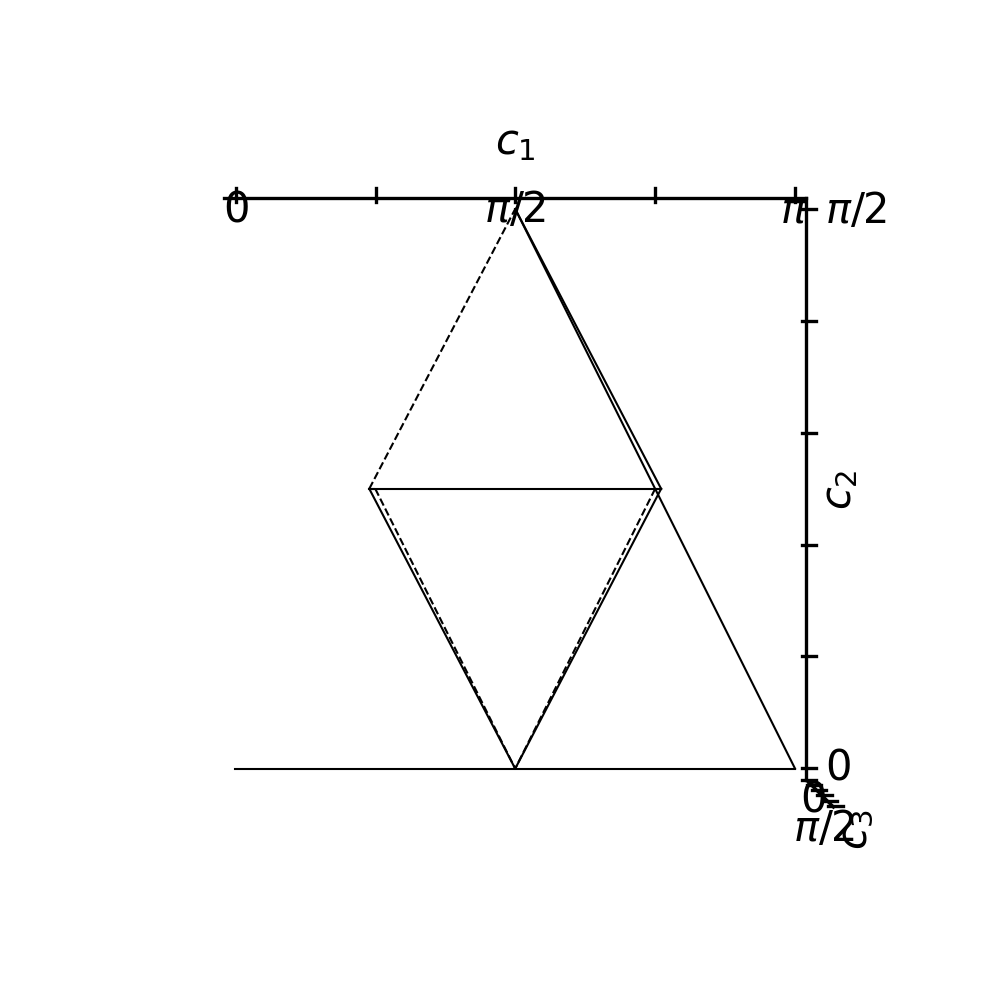

In [76]:
w.plot()

In [35]:
# save fig as pdf
from slam.utils.visualize import fpath_images
fig.savefig(f'{fpath_images}/speed_limit.pdf', bbox_inches='tight')
#save as svg
fig.savefig(f'{fpath_images}/speed_limit.svg', bbox_inches='tight')

# Resume 

In [157]:
#rewrite ConversionGainGate to have a cost function that is dynamic in the parameters
from slam.utils.gates.custom_gates import ConversionGainGate
class SpeedLimitedGate(ConversionGainGate):
    def __init__(self, p1, p2, g1, g2, t_el, speed_limit_function):
        self.g1 = g1 #conversion
        self.g2 = g2 #gain
        self.t_el = t_el
        self.slf = speed_limit_function
        super().__init__(p1, p2, g1, g2, t_el)
        
    def cost(self):
        assert not (self.g1 == 0 and self.g2 ==0)
        #norm = np.pi/2 # TODO move norm from preprocessing into here
        # get upper bound of g terms from speed limit data
        xs = np.linspace(0, np.pi/2, N) #XXX, danger! assumes the max intercept was on the x-axis (assumes y-axis intercept is np.pi/2)

        if self.g1 == 0: #avoid case when ratio is undefined by only scaling 
            idx = 0
            scaled_g1, scaled_g2 = float(xs[idx]), float(s(xs[idx]))
        else:
            ratio = self.g2/self.g1 * xs
            idx = max(np.argwhere(np.abs(ratio - self.slf(xs)) < 0.02))[0]
            scaled_g1, scaled_g2 = float(xs[idx]), float(ratio[idx]) #conversion, gain
        
        #inversely scale time for new g terms
        # should be the same unless either g1 or g2 is 0
        if self.g1 == 0:
            scale = scaled_g2/self.g2
        else:
            scale = scaled_g1/self.g1

        # if scale < 1 means we are decreasing strength, so increase time
        scaled_t = self.t_el / scale

        #cost is duration of gate
        return scaled_t

In [151]:
c = ConversionGainGate(0, 0, .25*np.pi, .25*np.pi, 1) #using vanilla class same as linear speed limit
c.cost()

1.0

In [160]:
c = SpeedLimitedGate(0, 0, .25*np.pi, .25*np.pi, 1, speed_limit_function=s)
c.cost()

3.049618320610687

In [161]:
s2 = lambda x: -x + np.pi/2
d = SpeedLimitedGate(0, 0, .25*np.pi, .25*np.pi, 1, speed_limit_function=s2)
d.cost()
#rounding error when finding intersection?

0.9888613861386139

In [162]:
e = SpeedLimitedGate(*[0, 0, 0.009817477042468103, 0.18653206380689397, 1], speed_limit_function=s)
e.cost()

0.62421875

[0.78736658] [0.78736658]


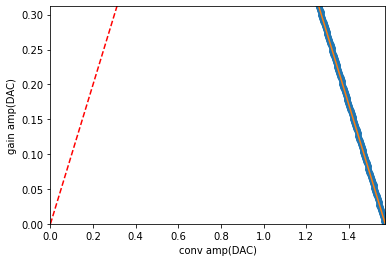

In [163]:
# step 3 univariate spline
from scipy.interpolate import UnivariateSpline
N=400
plt.figure()
s2 = lambda x: -x + np.pi/2
xs = np.linspace(0, np.pi/2, N)

plt.plot(xs, s2(xs), 'o-', xs, s2(xs))
plt.ylabel("gain amp(DAC)")
plt.xlabel('conv amp(DAC)')
plt.xlim(0,max(xs))
plt.ylim(0,max(s(xs)))

#plot cnot gate
gate_c = 0.25*np.pi
gate_g = 0.25*np.pi
if gate_c == 0:
    plt.plot([0, 0], [0, max(s(xs))], 'ro')
else:
    ratio = gate_g/gate_c * xs
    plt.plot(xs, ratio, 'r--')

if gate_c == 0:
    idx = 0
    print(xs[idx], s2(xs[idx]))
else:
    idx = max(np.argwhere(np.abs(ratio - s2(xs)) < 0.01))
    print(xs[idx], ratio[idx])
plt.plot(xs[idx], s2(xs[idx]), 'ro')
plt.show()

In [164]:
np.pi/2

1.5707963267948966